In [1]:
]activate ../.

 Activating environment at `~/Documents/Julia/SEM/SEM.jl/Project.toml`


In [8]:
using Revise
using SEM
using LinearAlgebra, Plots, UnPack, Setfield
using Zygote, Flux
using Statistics

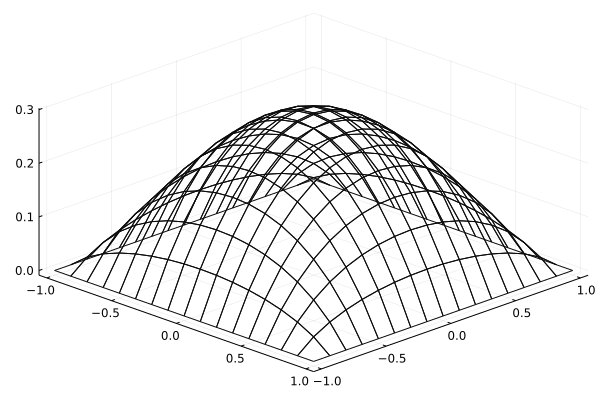

In [3]:
Ex = 16; nr1 = 2;
Ey = 16; ns1 = 2;

ifperiodic = [false,false]
m1 = Mesh(nr1,ns1,Ex,Ey,ifperiodic)
bc = ['D','D','D','D']

setIC(u,x,y,t) = 0.0 .*u
setBC(ub,x,y,t) = @. 0+0*x
setForcing(f,x,y,t) = @. 1+0*x
setVisc(ν,x,y,t) = @. 1+0*x

sch = DiffusionScheme(setIC,setBC,setForcing,setVisc)
dfn = Diffusion(bc,m1,sch,Tf=0.0,dt=0.00)

sim!(dfn)
utrue = dfn.fld.u

meshplt(utrue,m1)

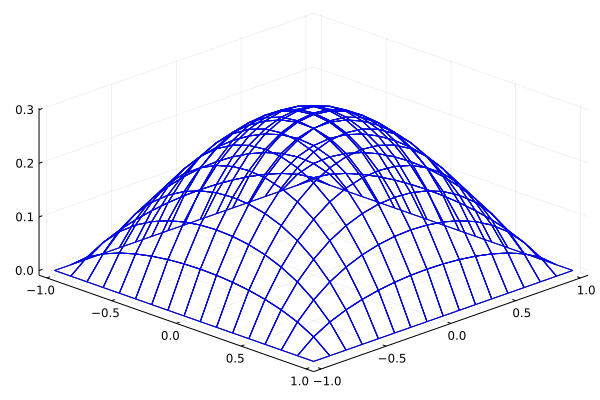

loss() = 2.3203416233173405e-9


2.3203416233173405e-9

In [5]:
# Learn ν #

p0_ν = [2.]
learnVisc(ν,x,y,t) = @. p0_ν+0*x

sch_ν = @set sch.setVisc = learnVisc
dfn_ν = Diffusion(bc,m1,sch_ν,Tf=0.0,dt=0.00)

function model()
    sim!(dfn_ν)
    upred = dfn_ν.fld.u
end

function loss()
    upred = model()
    mean(abs2,upred.-utrue)
end

function cb()
    @show loss()
    plt = meshplt(utrue,m1); plt = meshplt!(m1.x,m1.y,model(),c=:blue); 
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([p0_ν])
opt = ADAM(1e-2)
Flux.train!(loss,ps,Iterators.repeated((), 200),opt, cb = Flux.throttle(cb,.5))
plt = meshplt(utrue,m1); plt = meshplt!(m1.x,m1.y,model(),c=:blue); display(plt)
@show loss()

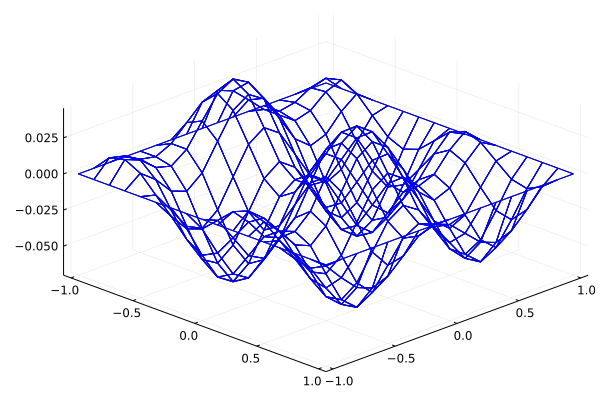

loss() = 7.194112617797773e-9


7.194112617797773e-9

In [6]:
# Learn f #

sinForcing(f,x,y,t) = @. sin(2*pi*x)+cos(2*pi*y)
sch = @set sch.setForcing = sinForcing
dfn = Diffusion(bc,m1,sch,Tf=0.0,dt=0.00)

sim!(dfn)
utrue2 = dfn.fld.u

p0_f = .1 .*ones(size(dfn.f)...)
learnForce(f,x,y,t) = p0_f

sch_f = @set sch.setForcing = learnForce
dfn_f = Diffusion(bc,m1,sch_f,Tf=0.0,dt=0.00)

function model()
    sim!(dfn_f)
    upred = dfn_f.fld.u
end

function loss()
    upred = model()
    mean(abs2,upred.-utrue2)
end

function cb()
    @show loss()
    plt = meshplt(utrue2,m1); plt = meshplt!(m1.x,m1.y,model(),c=:blue); 
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([p0_f])
opt = ADAM(1e-2)
Flux.train!(loss,ps,Iterators.repeated((), 2000),opt, cb = Flux.throttle(cb,1))
plt = meshplt(utrue2,m1); plt = meshplt!(m1.x,m1.y,model(),c=:blue); display(plt)
@show loss()

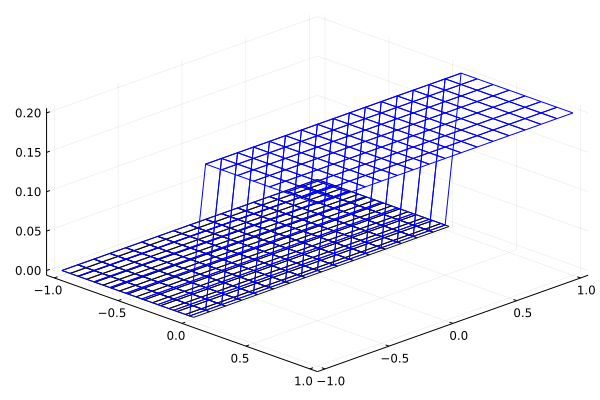

loss() = 0.0


0.0

In [25]:
# Learn mesh #

stepForcing(f,x,y,t) = @. 1*(x>0) + 0*x
sch_m = @set sch.setForcing = stepForcing

b = [1.]
function deform(x,y)
    x = x.*(b.+1)./2 .-(-(b.+1)./2 .+1)
    return x,y
end

function model()
    m2 = Mesh(nr1,ns1,Ex,Ey,ifperiodic,deform)
    dfn_m = Diffusion(bc,m2,sch_m,Tf=0.0,dt=0.00)
    sim!(dfn_m)
    upred = dfn_m.fld.u
    return upred, m2, dfn_m
end

function loss()
    upred = model()[1]
    sum(abs2,upred)
end

function cb()
    @show loss()
    up,m,d = model()
    plt = meshplt(up,m); plt = meshplt!(m1.x,m1.y,0.2 .*stepForcing(1,m1.x,m1.y,1),c=:blue); 
    display(plt)
    IJulia.clear_output(true);
end

ps = Params([b])
opt = ADAM(5e-3)
Flux.train!(loss,ps,Iterators.repeated((), 200),opt, cb = Flux.throttle(cb,.2))
opt = ADAM(2e-2)
Flux.train!(loss,ps,Iterators.repeated((), 50),opt, cb = Flux.throttle(cb,.2))
up,m,d = model()
plt = meshplt(up,m); plt = meshplt!(m1.x,m1.y,0.2 .*stepForcing(1,m1.x,m1.y,1),c=:blue); display(plt) 
@show loss()


In [19]:
b

1-element Array{Float64,1}:
 0.013351131122424118